### Setup and Initialisation

##### Installing Rtree [Only for Google Colab]

In [0]:
import os
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!ldconfig
!pip install rtree

#restart runtime
os.kill(os.getpid(), 9)

##### Library Installs

In [0]:
!pip install h3
!pip install geopandas
!pip install hdbscan
%cd drive/My\ Drive/Data/MAUP

  Created wheel for h3: filename=h3-3.4.3-cp36-cp36m-linux_x86_64.whl size=81855 sha256=310c4fc52f00b1a2069b6c763163feae7b5a9ec21a7e2ed4859f446447d200e1
  Stored in directory: /root/.cache/pip/wheels/7f/8e/74/c5ae2b6a5e3f28239b9bea822e38a08075a5eb05589a0d2a7c
Successfully built h3
     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 209kB/s 
     |████████████████████████████████| 10.9MB 52.5MB/s 
     |████████████████████████████████| 4.7MB 2.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2358780 sha256=c19a3f982d54ce0348e11ec096e12908fb58980887c81d787336be46942447df
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
[Errno 2] No such file or directory: 'drive/My Drive/Data/MAUP'
/cont

##### Imports

In [0]:
import warnings
import os
from datetime import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point
from h3 import h3


warnings.filterwarnings('ignore')

### Auxiliary Functions

In [0]:
def geoToHex(data, res):
  '''
  Computes Hexagon IDs from Latitude, Longitude data. For more information visit: https://github.com/uber/h3-py

  Input: data: 2D array of geolocations [[lat, lng],]
         res: resolution at which the hexagon should be computed.
  Output: 1D array of hexagon ids [hex_id,]
  '''
  l = []
  for i in data:
    l.append(h3.geo_to_h3(i[0], i[1], res))
  return l



def computeMPPerHexagon(data, key, writeCsv=True):
  '''
  This function computes Market potential M.P for an areal unit X
  Input: data->Pandas dataframe, key-> column for unique identifier for the area X (a hexagon)
  Output: Pandas DataFrame: [hex_id, market_potential, total_ubertaxi_rides, total_yellowtaxi_rides] and/or csv for the same
  
  '''

  #one-hot encde taxi type
  x = pd.get_dummies(data['type'])

  #concatenate with data
  x = pd.concat([data,pd.get_dummies(data['type'])],axis=1)

  #group by selected area : hexagon
  x = x.groupby(key).agg({"uber_taxi":"sum", "yellow_taxi":"sum"}).reset_index()

  #find market pootential
  MP = x['yellow_taxi'] / ( x['yellow_taxi'] + x['uber_taxi'] )
  x['market_potential'] = MP

  #rename columns to their new meanings
  x.rename(columns={key:"h3_id", "uber_taxi":"total_ubertaxi_rides", "yellow_taxi":"total_yellowtaxi_rides"}, inplace=True)
 
  #generate csv for mapping on keplers
  if(writeCsv):
    x.to_csv("results/"+key+".csv", index=False)

  return x



def computeMPPerPolygon(data, key, writeCsv=True):
  '''
  This function computes Market potential M.P for an areal unit X
  Input: data->Pandas dataframe, key-> column for unique identifier for the area X (a polygon), area_geometry-> column for gemetry for area defined by key
  Output: Pandas DataFrame: [area_id, area_geometry, market_potential, total_ubertaxi_rides, total_yellowtaxi_rides] and/or csv for the same
  
  '''
  #one-hot encde taxi type
  x = pd.get_dummies(data['type'])

  #concatenate with data
  x = pd.concat([data,pd.get_dummies(data['type'])],axis=1)

  #parse to int datatype
  x['yellow_taxi'] = x['yellow_taxi'].astype(int)
  x['uber_taxi'] = x['uber_taxi'].astype(int)

  #group by selected area : hexagon
  x = x.groupby(key+"_id").agg({"uber_taxi":"sum", "yellow_taxi":"sum", key+"_geometry": list}).reset_index()

  #extract gemetries from sets.
  x[key+"_geometry"] = x[key+"_geometry"].apply(lambda x: x[0])

  #find market pootential
  MP = x['yellow_taxi'] / ( x['yellow_taxi'] + x['uber_taxi'] )
  x['market_potential'] = MP

  #rename columns to their new meanings
  x.rename(columns={key:"h3_id", "uber_taxi":"total_ubertaxi_rides", "yellow_taxi":"total_yellowtaxi_rides"}, inplace=True)
  
  #generate csv for mapping on keplers
  if(writeCsv):
    x.to_csv("results"+"/"+key+".csv", index=False)

  return x


def cutoff(data, cutoff):
  ''' 
  This function filters a pandas dataframe by a given cutoff (an integer)
  '''
  data = data[ (data.total_ubertaxi_rides >= cutoff) & (data.total_yellowtaxi_rides>=cutoff)]
  return data



def getPolygon(x):
  ''' This function computes the convex hull of a set of latitude, longitude.
  Input: 2D numpy array of floats
  Output: NaN if convexhull cannot be resolved
          Shapely POLYGON geometry (the convex hull)
  '''
  x = x[['lon', 'lat']].values
  x = np.unique(x, axis=0)
  if(x.shape[0]<=2):
    return np.nan
  try:
    hull = ConvexHull(x)
    return Polygon(x[hull.vertices])
  except:
    return np.nan



### Main Code

#### Optional Section

##### Process Raw Yellow Taxi Data

In [0]:
# from google.colab import auth
# import google.datalab.bigquery as bq


# auth.authenticate_user()
# os.environ['PROJECT_ID'] = 'data-275417'

# Create and run a SQL query for the taxi_data from 2014, April, 01
query = bq.Query('(SELECT pickup_datetime,  pickup_latitude, pickup_longitude FROM `bigquery-public-data.new_york.tlc_yellow_trips_2014` WHERE pickup_datetime>="2014-04-01 00:00:00" AND pickup_datetime<="2014-04-01 23:59:59" LIMIT 10000)')
output_options = bq.QueryOutput.table(use_cache=False)
result = query.execute(output_options=output_options).result()

# Convert to DataFrame
yellow_taxi = result.to_dataframe()
yellow_taxi.drop(columns=["pickup_datetime"], inplace=True)
yellow_taxi.rename(columns={"pickup_latitude":"lat", "pickup_longitude":"lon"}, inplace=True)

yellow_taxi.to_csv("yellowtaxi_locations_01042014.csv", index=False)
yellow_taxi.head()

,lat,lon
0,40.747577,-73.990733
1,40.734370,-73.990940
2,40.773287,-73.957660
3,40.726040,-73.989547
4,40.767507,-73.966557


##### Process Raw Uber Taxi Data

In [0]:
# data avaiable here: https://www.kaggle.com/fivethirtyeight/uber-pickups-in-new-york-city#uber-raw-data-apr14.csv
uber_taxi = pd.read_csv('uber-raw-data-apr14.csv.zip', parse_dates=['Date/Time'])
uber_taxi = uber_taxi[['Date/Time', 'Lat', 'Lon']]
uber_taxi = uber_taxi[ (uber_taxi['Date/Time'].dt.month==4) & (uber_taxi['Date/Time'].dt.day==1)]
uber_taxi.drop(columns=["Date/Time"], inplace=True)
uber_taxi.rename(columns={"Lat":"lat", "Lon":"lon"}, inplace=True)
uber_taxi.head()

,lat,lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722


In [0]:
uber_taxi.to_csv("uber_locations_01042014.csv", index=False)

#### Data Load and Preporcessing

* This section reads data for Yellow Taxis and Uber Taxis and performs the following transformations on it:
> 1. Attach categorical column **type** to both datasets. **type** can be *yellow_taxi* or *uber_taxi*.
> 2. Merge both dataset to create single taxi dataframe called **data**. 
> 3. Remove *null* and *0* valued latitude and longitudes

##### Read Yellow Taxi Location Data

In [0]:
#read processed yellow taxi locations data
yellow_taxi = pd.read_csv("taxi_location_data_processed/yellowtaxi_locations_01042014.csv")
yellow_taxi.head()

,lat,lon
0,40.747577,-73.990733
1,40.734370,-73.990940
2,40.773287,-73.957660
3,40.726040,-73.989547
4,40.767507,-73.966557


In [0]:
#find out total Yellow Taxi rides
print("Total Yellow Taxi Rides: {}".format(yellow_taxi.shape[0]))

Total Yellow Taxi Rides: 10000


In [0]:
#assing id = 1 for uber cabs
yellow_taxi = yellow_taxi.assign(type="yellow_taxi")
yellow_taxi.head()

,lat,lon,type
0,40.747577,-73.990733,yellow_taxi
1,40.734370,-73.990940,yellow_taxi
2,40.773287,-73.957660,yellow_taxi
3,40.726040,-73.989547,yellow_taxi
4,40.767507,-73.966557,yellow_taxi


##### Read Uber Location Data

In [0]:
#read processed uber locations data
uber_taxi = pd.read_csv("taxi_location_data_processed/uber_locations_01042014.csv")
uber_taxi.head()

,lat,lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722


In [0]:
#find out total uber rides
print("Total Uber Rides: {}".format(uber_taxi.shape[0]))

Total Uber Rides: 14546


In [0]:
#assing id = 1 for uber cabs
uber_taxi = uber_taxi.assign(type="uber_taxi")
uber_taxi.head()

,lat,lon,type
0,40.7690,-73.9549,uber_taxi
1,40.7267,-74.0345,uber_taxi
2,40.7316,-73.9873,uber_taxi
3,40.7588,-73.9776,uber_taxi
4,40.7594,-73.9722,uber_taxi


##### Create All Taxis

In [0]:
#merge both datasets to generate single dataframe 
data = pd.concat([yellow_taxi, uber_taxi], axis=0)
data.head()

,lat,lon,type
0,40.747577,-73.990733,yellow_taxi
1,40.734370,-73.990940,yellow_taxi
2,40.773287,-73.957660,yellow_taxi
3,40.726040,-73.989547,yellow_taxi
4,40.767507,-73.966557,yellow_taxi


In [0]:
#check total number of rides
print("Total Rides: {}".format(data.shape[0]))

Total Rides: 24546


In [0]:
#validate if merge took place correctly by checking value counts for ID.
data.type.value_counts()

uber_taxi      14546
yellow_taxi    10000
Name: type, dtype: int64

In [0]:
#remove invalid lat, lon (if any)
data = data[~(data.lat==0)]
data = data[~(data.lon==0)]
data = data[~(data.lat.isna())]
data = data[~(data.lon.isna())]

#check total number of rides
print("Total Rides after cleanup: {}".format(data.shape[0]))

Total Rides after cleanup: 24415


#### Calulating Market Potential for Socially Defined Areas

* In this section, we will be calculating the **Market Potential (MP)** for each area defined by zip codes, housing, etc. 

* This section focuses on finding out if there are any variations in the calculated **MP** when *different* area definitions are used to calculate the same metric.

* All the shapefiles used can be found here: [Data Source](https://https://geodata.lib.berkeley.edu/)
> Areas by:
> 1. [Zip Codes](https://geodata.lib.berkeley.edu/download/file/nyu-2451-34509-geojson.json)
> 2. [Housing](https://geodata.lib.berkeley.edu/download/file/nyu-2451-34204-geojson.json)


In [0]:
#  setting up CRS for geospatial geometries. Find out more about it here: https://www.w3.org/2015/spatial/wiki/Coordinate_Reference_Systems
crs = {'init': 'epsg:4326'}

# convert pandas dataframe to geopandas dataframe
data_gdf = gpd.GeoDataFrame(data, crs=crs, geometry=[Point(xy) for xy in zip(data.lon, data.lat)])

# base_url for different area shapfiles for NYC
url="https://geodata.lib.berkeley.edu/download/file/"

# select these shapefiles to work with. Each file represents a different area definition
area_shape_files={
    
    "nyu-2451-34509-geojson.json":"zip_code",
    "nyu-2451-34204-geojson.json":"housing"

}

# iterate over each area file [ you can extract the code out of the for loop to see how data transforms at each line. ]

for i in area_shape_files.keys():
  try:
    area_gdf = gpd.read_file(url+i, crs=crs) # read geoJSON shapefile for area i
    area_gdf = area_gdf[['id','geometry']] # use only columns id, geometry

    #__spatially join our based rides data with each area. Finds out which ride happened in which area
    data_gdf = sjoin(area_gdf, data_gdf, how='inner', op='contains') 

    #beautifying area ids
    data_gdf["id"] = data_gdf["id"].apply(lambda x: area_shape_files[i]+"_"+x[15:])

    #some cosmetic changes
    data_gdf.drop(columns=["index_right"], inplace=True) 
    data_gdf.rename(columns={"id":area_shape_files[i]+"_"+"id", "geometry":area_shape_files[i]+"_"+"geometry"}, inplace=True)

    
    #re-attach geos to compute over again.
    data_gdf['geometry']=[Point(xy) for xy in zip(data_gdf.lon, data_gdf.lat)]

  except:
   print("Error in File: {}".format(i))

#cosmetic changes and conversion back to pandas dataframe
data_gdf.drop(columns=["geometry"], inplace=True)
data = pd.DataFrame(data_gdf)
data.head()

,housing_id,housing_geometry,election_id,election_geometry,zip_code_id,zip_code_geometry,lat,lon,type
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",zip_code_129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ...",40.716000,-73.934200,uber_taxi
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",zip_code_129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ...",40.716100,-73.934300,uber_taxi
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.721200,-73.938300,uber_taxi
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.723605,-73.938512,yellow_taxi
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.724500,-73.936400,uber_taxi


In [0]:
#re-arraning columns for ease of understanding
column_order = ["type","lat", "lon"] + [x for x in data.columns if x not in ["type","lat", "lon"]]
data = data[column_order]
data.head()

,type,lat,lon,housing_id,housing_geometry,election_id,election_geometry,zip_code_id,zip_code_geometry
0,uber_taxi,40.716000,-73.934200,nyu_2451_34204.1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",nyu_2451_34206.4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",nyu_2451_34509.129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ..."
0,uber_taxi,40.716100,-73.934300,nyu_2451_34204.1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",nyu_2451_34206.4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",nyu_2451_34509.129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ..."
0,uber_taxi,40.721200,-73.938300,nyu_2451_34204.1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",nyu_2451_34206.3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",nyu_2451_34509.140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ..."
0,yellow_taxi,40.723605,-73.938512,nyu_2451_34204.1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",nyu_2451_34206.3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",nyu_2451_34509.140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ..."
0,uber_taxi,40.724500,-73.936400,nyu_2451_34204.1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",nyu_2451_34206.3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",nyu_2451_34509.140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ..."


In [0]:
#calclating M.P fo each area type
housing = computeMPPerPolygon(data, "housing")
zip_code = computeMPPerPolygon(data, "zip_code")

#### Calulating Market Potential for Hexagons

* In this section, we restrict our analysis to a particular **shape** to understand and find out if it helps solve the Shape problem in MAUP. 

* Here, we are using HEXAGONS as the shape. Also, we analyse Market Potential at different **scales** to find out wether restricting shape helps or not.

* We'll be using Uber's H3 library to get the hexagons for each lat, lng. More information on it can be found here: [Uber H3](https://https://github.com/uber/h3)



In [0]:
# various hexagon resolutions to be used
resolutions = [7,8,9]
for i in resolutions:
  data["h3_id_"+str(i)] = geoToHex(data[['lat', 'lon']].values, i)

In [0]:
data.head()

,housing_id,housing_geometry,election_id,election_geometry,zip_code_id,zip_code_geometry,lat,lon,type,h3_id_7,h3_id_8,h3_id_9,h3_id_10
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",zip_code_129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ...",40.716000,-73.934200,uber_taxi,872a100d1ffffff,882a100d13fffff,892a100d137ffff,8a2a100d134ffff
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_4465,"MULTIPOLYGON (((-73.92412 40.71769, -73.92410 ...",zip_code_129,"MULTIPOLYGON (((-73.95568 40.72394, -73.95627 ...",40.716100,-73.934300,uber_taxi,872a100d1ffffff,882a100d13fffff,892a100d137ffff,8a2a100d134ffff
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.721200,-73.938300,uber_taxi,872a100d1ffffff,882a100d11fffff,892a100d107ffff,8a2a100d106ffff
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.723605,-73.938512,yellow_taxi,872a100d1ffffff,882a100d11fffff,892a100d117ffff,8a2a100d115ffff
0,housing_1,"MULTIPOLYGON (((-73.92390 40.71978, -73.92397 ...",election_3609,"MULTIPOLYGON (((-73.92781 40.72506, -73.92920 ...",zip_code_140,"MULTIPOLYGON (((-73.95568 40.72394, -73.95615 ...",40.724500,-73.936400,uber_taxi,872a100d1ffffff,882a100d11fffff,892a100d117ffff,8a2a100d116ffff


In [0]:
#calculatin M.Ps per hexagonal area
resolutions = [7,8,9]
for i in resolutions:
  computeMPPerHexagon(data, "h3_id_"+str(i))

Using these data files, we plotted the results on our platform. You can use any other visualisation tool too such as Folium, Plotly, etc.

![alt text](https://)

#### Infered Areas

In [0]:
from sklearn.cluster import OPTICS, DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import hdbscan


In [0]:
coords = data[['lat', 'lon']].values
kms_per_radian = 6371.0088
epsilon = 100
db = OPTICS(max_eps=epsilon, min_samples = 2, min_cluster_size=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
data["cluster_id"] = cluster_labels
data.cluster_id.value_counts()

-1       10520
 146        49
 110        22
 1521       20
 145        18
         ...  
 376         5
 360         5
 344         5
 312         5
 0           5
Name: cluster_id, Length: 1884, dtype: int64

Noise Total: 4517 out of 24415 @ 18.500921564611918%


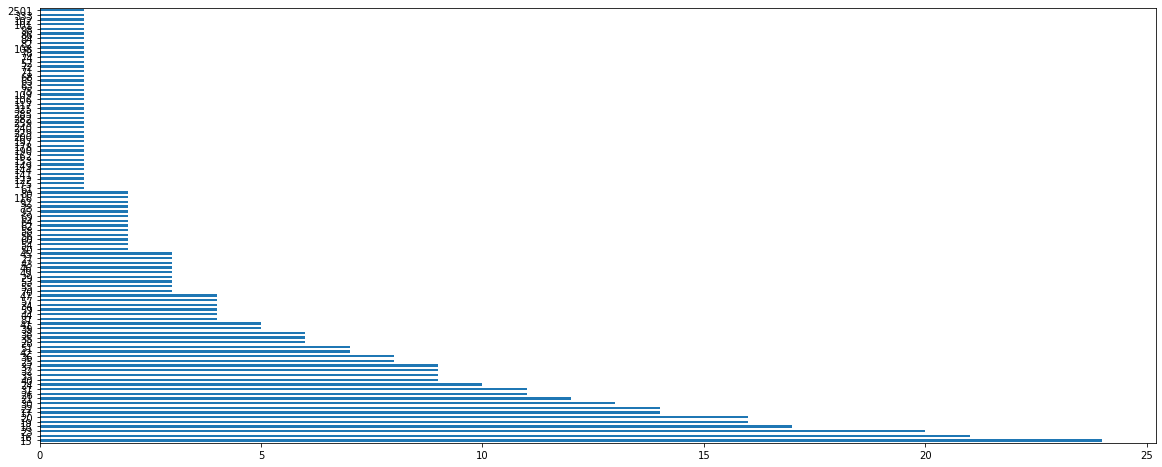

In [0]:
x = data
coords = np.radians(x[['lat', 'lon']].values)
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=15,cluster_selection_epsilon=0.03/6371, min_samples=2)
clusterer.fit(coords)
cluster_labels = clusterer.labels_
x["cluster_id"] = cluster_labels
print("Noise Total: {} out of {} @ {}%".format(x[x.cluster_id==-1].shape[0], x.shape[0], x[x.cluster_id==-1].shape[0]*100/x.shape[0]))
x = x[x.cluster_id!=-1]
x.cluster_id.value_counts().value_counts().plot(kind='barh', figsize=(20, 8))

In [0]:
data["cluster_id"] = cluster_labels

In [0]:
from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import ConvexHull
from shapely.geometry import MultiPoint



x = pd.DataFrame(data.groupby("cluster_id").apply(getPolygon)).reset_index()
data = pd.merge(data, x, on = "cluster_id",how="left")
data.dropna(inplace=True)
data.rename(columns={0:"infered_area_geometry", "cluster_id":"infered_area_id"}, inplace=True)

In [0]:
data

,lat,lon,type,infered_area_id,infered_area_geometry
0,40.747577,-73.990733,yellow_taxi,-1,"POLYGON ((-74.1148 40.3082, -73.417 40.7735, -..."
1,40.734370,-73.990940,yellow_taxi,359,"POLYGON ((-73.989254 40.734418, -73.989983 40...."
2,40.773287,-73.957660,yellow_taxi,257,"POLYGON ((-73.9594 40.7752, -73.9603 40.7738, ..."
3,40.726040,-73.989547,yellow_taxi,150,"POLYGON ((-73.9892 40.7263, -73.9903 40.7257, ..."
4,40.767507,-73.966557,yellow_taxi,226,"POLYGON ((-73.9661 40.7688, -73.966942 40.7673..."
...,...,...,...,...,...
24410,40.721900,-73.992000,uber_taxi,-1,"POLYGON ((-74.1148 40.3082, -73.417 40.7735, -..."
24411,40.726100,-74.002700,uber_taxi,320,"POLYGON ((-74.00291 40.728152, -74.003668 40.7..."
24412,40.736400,-73.992600,uber_taxi,321,"POLYGON ((-73.992401 40.738121, -73.99386 40.7..."
24413,40.714900,-73.940500,uber_taxi,-1,"POLYGON ((-74.1148 40.3082, -73.417 40.7735, -..."


In [0]:
x = computeMPPerPolygon(data, "infered_area")

#### Anaylsis of M.P

* This section focuses on analysing the Market Potential based on different areas obtained so far.

* We will be finding top 5 Market Potential Areas by the different area definitions we have made so far.

In [0]:
zip_code = pd.read_csv("results/zip_code.csv")
housing = pd.read_csv("results/housing.csv")
h3_id_7 = pd.read_csv("results/h3_id_7.csv")
h3_id_8 = pd.read_csv("results/h3_id_8.csv")
h3_id_9 = pd.read_csv("results/h3_id_9.csv")
infered = pd.read_csv("results/infered_area.csv")

In [0]:
housing = cutoff(housing, 10)
zip_code = cutoff(zip_code, 10)
h3_id_7 = cutoff(h3_id_7, 10)
h3_id_8 = cutoff(h3_id_8, 10)
h3_id_9 = cutoff(h3_id_9, 10)
infered = cutoff(infered, 10)

In [0]:
housing.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_housing.csv", index=False)
zip_code.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_zip_code.csv", index=False)
h3_id_7.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_hexagon_7.csv", index=False)
h3_id_8.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_hexagon_8.csv", index=False)
h3_id_9.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_hexagon_9.csv", index=False)
infered.nlargest(5, 'market_potential').to_csv("results/top5_mp_areas_by_infered_area.csv", index=False)